In [341]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import tensorflow as tf
from sklearn.model_selection import train_test_split
from keras.preprocessing.sequence import TimeseriesGenerator
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import matplotlib as mpl

mpl.rcParams['figure.figsize']=(20,20)
mpl.rcParams['axes.grid']=False

In [342]:
df = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/00374/energydata_complete.csv')

We are downloading the energy usage dataset from UCI database.

In [343]:
df.head()

,date,Appliances,lights,T1,RH_1,T2,RH_2,T3,RH_3,T4,...,T9,RH_9,T_out,Press_mm_hg,RH_out,Windspeed,Visibility,Tdewpoint,rv1,rv2
0,2016-01-11 17:00:00,60,30,19.89,47.596667,19.2,44.790000,19.79,44.730000,19.000000,...,17.033333,45.53,6.600000,733.5,92.0,7.000000,63.000000,5.3,13.275433,13.275433
1,2016-01-11 17:10:00,60,30,19.89,46.693333,19.2,44.722500,19.79,44.790000,19.000000,...,17.066667,45.56,6.483333,733.6,92.0,6.666667,59.166667,5.2,18.606195,18.606195
2,2016-01-11 17:20:00,50,30,19.89,46.300000,19.2,44.626667,19.79,44.933333,18.926667,...,17.000000,45.50,6.366667,733.7,92.0,6.333333,55.333333,5.1,28.642668,28.642668
3,2016-01-11 17:30:00,50,40,19.89,46.066667,19.2,44.590000,19.79,45.000000,18.890000,...,17.000000,45.40,6.250000,733.8,92.0,6.000000,51.500000,5.0,45.410389,45.410389
4,2016-01-11 17:40:00,60,40,19.89,46.333333,19.2,44.530000,19.79,45.000000,18.890000,...,17.000000,45.40,6.133333,733.9,92.0,5.666667,47.666667,4.9,10.084097,10.084097


Here we are predicting energy usage by Appliances in watts. The data provided has been collected every 10 minutes. We could use all the varaiables to predict or we could select a few. In this study, just to simplify, we will choose 4-5 features to predict. The time series data is sorted as per order. RH is humidity and T is temperature. Data is collected for each room. 

In [344]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19735 entries, 0 to 19734
Data columns (total 29 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   date         19735 non-null  object 
 1   Appliances   19735 non-null  int64  
 2   lights       19735 non-null  int64  
 3   T1           19735 non-null  float64
 4   RH_1         19735 non-null  float64
 5   T2           19735 non-null  float64
 6   RH_2         19735 non-null  float64
 7   T3           19735 non-null  float64
 8   RH_3         19735 non-null  float64
 9   T4           19735 non-null  float64
 10  RH_4         19735 non-null  float64
 11  T5           19735 non-null  float64
 12  RH_5         19735 non-null  float64
 13  T6           19735 non-null  float64
 14  RH_6         19735 non-null  float64
 15  T7           19735 non-null  float64
 16  RH_7         19735 non-null  float64
 17  T8           19735 non-null  float64
 18  RH_8         19735 non-null  float64
 19  T9  

The details given below are as provided by UCI about the columns.

In [ ]:
date time year-month-day hour:minute:second 
Appliances, energy use in Wh
lights, energy use of light fixtures in the house in Wh
T1, Temperature in kitchen area, in Celsius
RH_1, Humidity in kitchen area, in %
T2, Temperature in living room area, in Celsius
RH_2, Humidity in living room area, in %
T3, Temperature in laundry room area
RH_3, Humidity in laundry room area, in %
T4, Temperature in office room, in Celsius
RH_4, Humidity in office room, in %
T5, Temperature in bathroom, in Celsius
RH_5, Humidity in bathroom, in %
T6, Temperature outside the building (north side), in Celsius
RH_6, Humidity outside the building (north side), in %
T7, Temperature in ironing room , in Celsius
RH_7, Humidity in ironing room, in %
T8, Temperature in teenager room 2, in Celsius
RH_8, Humidity in teenager room 2, in %
T9, Temperature in parents room, in Celsius
RH_9, Humidity in parents room, in %
To, Temperature outside (from Chievres weather station), in Celsius
Pressure (from Chievres weather station), in mm Hg
RH_out, Humidity outside (from Chievres weather station), in %
Wind speed (from Chievres weather station), in m/s
Visibility (from Chievres weather station), in km
Tdewpoint (from Chievres weather station), Â°C
rv1, Random variable 1, nondimensional
rv2, Random variable 2, nondimensional


In [346]:
df.isnull().sum()

date           0
Appliances     0
lights         0
T1             0
RH_1           0
T2             0
RH_2           0
T3             0
RH_3           0
T4             0
RH_4           0
T5             0
RH_5           0
T6             0
RH_6           0
T7             0
RH_7           0
T8             0
RH_8           0
T9             0
RH_9           0
T_out          0
Press_mm_hg    0
RH_out         0
Windspeed      0
Visibility     0
Tdewpoint      0
rv1            0
rv2            0
dtype: int64

The data has no missing values. However it may have outliers. Usually we can do EDA and wrangling to check for outliers and duplicates. However as of now we will proceed with preprocessing and modeling.

In [347]:
# Converting date in date time format
df['date'] = pd.to_datetime(df.date)

In [348]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19735 entries, 0 to 19734
Data columns (total 29 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   date         19735 non-null  datetime64[ns]
 1   Appliances   19735 non-null  int64         
 2   lights       19735 non-null  int64         
 3   T1           19735 non-null  float64       
 4   RH_1         19735 non-null  float64       
 5   T2           19735 non-null  float64       
 6   RH_2         19735 non-null  float64       
 7   T3           19735 non-null  float64       
 8   RH_3         19735 non-null  float64       
 9   T4           19735 non-null  float64       
 10  RH_4         19735 non-null  float64       
 11  T5           19735 non-null  float64       
 12  RH_5         19735 non-null  float64       
 13  T6           19735 non-null  float64       
 14  RH_6         19735 non-null  float64       
 15  T7           19735 non-null  float64       
 16  RH_7

In [349]:
# lets check our data
df.describe()

,Appliances,lights,T1,RH_1,T2,RH_2,T3,RH_3,T4,RH_4,...,T9,RH_9,T_out,Press_mm_hg,RH_out,Windspeed,Visibility,Tdewpoint,rv1,rv2
count,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,...,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000
mean,97.694958,3.801875,21.686571,40.259739,20.341219,40.420420,22.267611,39.242500,20.855335,39.026904,...,19.485828,41.552401,7.411665,755.522602,79.750418,4.039752,38.330834,3.760707,24.988033,24.988033
std,102.524891,7.935988,1.606066,3.979299,2.192974,4.069813,2.006111,3.254576,2.042884,4.341321,...,2.014712,4.151497,5.317409,7.399441,14.901088,2.451221,11.794719,4.194648,14.496634,14.496634
min,10.000000,0.000000,16.790000,27.023333,16.100000,20.463333,17.200000,28.766667,15.100000,27.660000,...,14.890000,29.166667,-5.000000,729.300000,24.000000,0.000000,1.000000,-6.600000,0.005322,0.005322
25%,50.000000,0.000000,20.760000,37.333333,18.790000,37.900000,20.790000,36.900000,19.530000,35.530000,...,18.000000,38.500000,3.666667,750.933333,70.333333,2.000000,29.000000,0.900000,12.497889,12.497889
50%,60.000000,0.000000,21.600000,39.656667,20.000000,40.500000,22.100000,38.530000,20.666667,38.400000,...,19.390000,40.900000,6.916667,756.100000,83.666667,3.666667,40.000000,3.433333,24.897653,24.897653
75%,100.000000,0.000000,22.600000,43.066667,21.500000,43.260000,23.290000,41.760000,22.100000,42.156667,...,20.600000,44.338095,10.408333,760.933333,91.666667,5.500000,40.000000,6.566667,37.583769,37.583769
max,1080.000000,70.000000,26.260000,63.360000,29.856667,56.026667,29.236000,50.163333,26.200000,51.090000,...,24.500000,53.326667,26.100000,772.300000,100.000000,14.000000,66.000000,15.500000,49.996530,49.996530


There is a some range difference. To fix this we have to scale the data. We could either use Standard Scaler or Min Max Scaler. We would go with Min Max scaler here as it will not disturb the outliers, neither will it change the distribution of the data. 

We have two options which applying scaling, we could either apply it on the whole dataset, which we are doing here or to make it more precise, we could first apply it on the train data and then use those parameters to scale the test data. 

In [350]:
#create a new dataset which includes your input/output features, exclude date, lagged Total accidents and Wind_chill with 50% missing values 
df_input=df[['Appliances','T1','RH_1','T2','RH_2']]

df_input.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19735 entries, 0 to 19734
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Appliances  19735 non-null  int64  
 1   T1          19735 non-null  float64
 2   RH_1        19735 non-null  float64
 3   T2          19735 non-null  float64
 4   RH_2        19735 non-null  float64
dtypes: float64(4), int64(1)
memory usage: 771.0 KB


In [351]:
scaler=MinMaxScaler()
data_scaled=scaler.fit_transform(df_input)

In [352]:
#Lets check the output
data_scaled

array([[0.04672897, 0.32734952, 0.56618659, 0.22534529, 0.68403787],
       [0.04672897, 0.32734952, 0.54132648, 0.22534529, 0.68213984],
       [0.03738318, 0.32734952, 0.53050179, 0.22534529, 0.67944512],
       ...,
       [0.24299065, 0.91974657, 0.53866618, 0.69265118, 0.62719762],
       [0.38317757, 0.91974657, 0.54949087, 0.67705355, 0.63471741],
       [0.39252336, 0.91974657, 0.53875791, 0.66617051, 0.63290173]])

In [353]:
type(data_scaled)

numpy.ndarray

In [354]:
# We are defining the input and target varaibles. Features will be the input.
features=data_scaled# this will be all including Appliances
target= data_scaled[:,0] # this will be only Appliances

In [365]:
# just testing, where we are taking 20 minutes of data so length is 2 and predicting for the 30th minute.
TimeseriesGenerator(features,target,length=2,sampling_rate=1,batch_size=1)[0]

(array([[[0.04672897, 0.32734952, 0.56618659, 0.22534529, 0.68403787],
         [0.04672897, 0.32734952, 0.54132648, 0.22534529, 0.68213984]]]),
 array([0.03738318]))

We are splitting the data with test as 20% and shuffle will be False so that we preserve the order.

In [356]:
x_train, x_test, y_train, y_test=train_test_split(features, target, test_size=0.20, random_state=123, shuffle=False)

In [357]:
x_train.shape

(15788, 5)

In [358]:
x_test.shape

(3947, 5)

Now we will define the actual Timeseries generator

In [359]:
win_length=720 # 1 hr is 6 data points, so daily 144 datapts, we are using 5 days predict for 6th day 
batch_size=32 # training has to be faster so in each instance we are passing 32 batch size of data
num_features=5 # number of input features
# we are generating a train generator and a test generator.
train_generator = TimeseriesGenerator(x_train,y_train, length=win_length, sampling_rate=1, batch_size=batch_size)
test_generator = TimeseriesGenerator(x_test,y_test, length=win_length, sampling_rate=1, batch_size=batch_size)

We are defining train generator and test generator separately with the same features

In [360]:
# testing 
train_generator[0]

(array([[[0.04672897, 0.32734952, 0.56618659, 0.22534529, 0.68403787],
         [0.04672897, 0.32734952, 0.54132648, 0.22534529, 0.68213984],
         [0.03738318, 0.32734952, 0.53050179, 0.22534529, 0.67944512],
         ...,
         [0.06542056, 0.50791975, 0.31584258, 0.33438333, 0.49123629],
         [0.05607477, 0.49736008, 0.31309054, 0.32711413, 0.48720592],
         [0.06542056, 0.49736008, 0.31107238, 0.32711413, 0.48551879]],
 
        [[0.04672897, 0.32734952, 0.54132648, 0.22534529, 0.68213984],
         [0.03738318, 0.32734952, 0.53050179, 0.22534529, 0.67944512],
         [0.03738318, 0.32734952, 0.52408036, 0.22534529, 0.6784141 ],
         ...,
         [0.05607477, 0.49736008, 0.31309054, 0.32711413, 0.48720592],
         [0.06542056, 0.49736008, 0.31107238, 0.32711413, 0.48551879],
         [0.06542056, 0.49736008, 0.30923768, 0.32469106, 0.48467523]],
 
        [[0.03738318, 0.32734952, 0.53050179, 0.22534529, 0.67944512],
         [0.03738318, 0.32734952, 0.5240803

Now this have 32 batches each of 720 data

Input shape here is 720x5, return_sequences=True,bcoz we need hidden state for each of the input sequence, but since it is time series, we want hidden state for each input.activation is Leaky Relu, we use dropout to avoid overfitting, final dense layer is 1 which is the ouput  

In [361]:
# Defining the model architecture for LSTM model
model = tf.keras.Sequential()
model.add(tf.keras.layers.LSTM(128, input_shape=(win_length,num_features), return_sequences=True))
model.add(tf.keras.layers.LeakyReLU(alpha=0.5))
model.add(tf.keras.layers.LSTM(128, return_sequences=True))
model.add(tf.keras.layers.LeakyReLU(alpha=0.5))
model.add(tf.keras.layers.Dropout(0.3))
model.add(tf.keras.layers.LSTM(64, return_sequences=False))
model.add(tf.keras.layers.Dropout(0.3))
model.add(tf.keras.layers.Dense(1))

In [362]:
model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_24 (LSTM)              (None, 720, 128)          68608     
                                                                 
 leaky_re_lu_16 (LeakyReLU)  (None, 720, 128)          0         
                                                                 
 lstm_25 (LSTM)              (None, 720, 128)          131584    
                                                                 
 leaky_re_lu_17 (LeakyReLU)  (None, 720, 128)          0         
                                                                 
 dropout_16 (Dropout)        (None, 720, 128)          0         
                                                                 
 lstm_26 (LSTM)              (None, 64)                49408     
                                                                 
 dropout_17 (Dropout)        (None, 64)               

This is the model architecture. It has around 250k params.

 Now we definethe model with a Early stopping,, we are not running for ever. So even though the epochs is 50, if there is no improvement in the validation loss function, then it can stop. Compiling the model with mean squared error, and metrics we are tracking is MeanAbsolute Error. Shuffle is again False. 

In [363]:

early_stopping=tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=2,mode='min')

model.compile(loss=tf.losses.MeanSquaredError(), optimizer=tf.optimizers.Adam(), metrics=[tf.metrics.MeanAbsoluteError()])

history = model.fit(train_generator, epochs=50, validation_data=test_generator, shuffle = False, callbacks=[early_stopping])

Epoch 1/50
471/471 [==============================] - 2415s 5s/step - loss: 0.0086 - mean_absolute_error: 0.0518 - val_loss: 0.0054 - val_mean_absolute_error: 0.0339
Epoch 2/50
471/471 [==============================] - 3354s 7s/step - loss: 0.0067 - mean_absolute_error: 0.0434 - val_loss: 0.0048 - val_mean_absolute_error: 0.0316
Epoch 3/50
471/471 [==============================] - 14175s 30s/step - loss: 0.0048 - mean_absolute_error: 0.0357 - val_loss: 0.0043 - val_mean_absolute_error: 0.0368
Epoch 4/50
471/471 [==============================] - 2987s 6s/step - loss: 0.0043 - mean_absolute_error: 0.0329 - val_loss: 0.0040 - val_mean_absolute_error: 0.0338
Epoch 5/50
471/471 [==============================] - 13998s 30s/step - loss: 0.0042 - mean_absolute_error: 0.0324 - val_loss: 0.0041 - val_mean_absolute_error: 0.0365
Epoch 6/50
471/471 [==============================] - 68880s 147s/step - loss: 0.0041 - mean_absolute_error: 0.0323 - val_loss: 0.0040 - val_mean_absolute_error: 0.03

In [366]:
model.evaluate_generator(test_generator, verbose=0)

C:\Users\Shweta\AppData\Local\Temp\ipykernel_16132\1625521884.py:1: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  model.evaluate_generator(test_generator, verbose=0)


[0.0035712148528546095, 0.029947632923722267]

In [367]:
predictions=model.predict_generator(test_generator)

C:\Users\Shweta\AppData\Local\Temp\ipykernel_16132\2533966764.py:1: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  predictions=model.predict_generator(test_generator)


In [368]:
predictions.shape[0]

3227

In [369]:
predictions

array([[0.06115487],
       [0.10198077],
       [0.12689869],
       ...,
       [0.04517734],
       [0.23909798],
       [0.21537215]], dtype=float32)

In [370]:
y_test


array([0.3364486 , 0.54205607, 0.28971963, ..., 0.24299065, 0.38317757,
       0.39252336])

In [371]:
x_test

array([[0.3364486 , 0.48574446, 0.30923768, 0.22049915, 0.5595651 ],
       [0.54205607, 0.48574446, 0.3055683 , 0.22534529, 0.55581592],
       [0.28971963, 0.48574446, 0.30455921, 0.22994912, 0.55009842],
       ...,
       [0.24299065, 0.91974657, 0.53866618, 0.69265118, 0.62719762],
       [0.38317757, 0.91974657, 0.54949087, 0.67705355, 0.63471741],
       [0.39252336, 0.91974657, 0.53875791, 0.66617051, 0.63290173]])

In [372]:
x_test[:,1:][win_length:]

array([[0.58078141, 0.20851298, 0.46280591, 0.32720967],
       [0.58078141, 0.18282726, 0.5233826 , 0.30162152],
       [0.58078141, 0.18466196, 0.57669009, 0.27162808],
       ...,
       [0.91974657, 0.53866618, 0.69265118, 0.62719762],
       [0.91974657, 0.54949087, 0.67705355, 0.63471741],
       [0.91974657, 0.53875791, 0.66617051, 0.63290173]])

In [373]:
df_pred=pd.concat([pd.DataFrame(predictions), pd.DataFrame(x_test[:,1:][win_length:])],axis=1)

In [374]:
df_pred

,0,0,1,2,3
0,0.061155,0.580781,0.208513,0.462806,0.327210
1,0.101981,0.580781,0.182827,0.523383,0.301622
2,0.126899,0.580781,0.184662,0.576690,0.271628
3,0.369549,0.580781,0.193996,0.622486,0.234324
4,0.149066,0.580781,0.181818,0.646717,0.213516
...,...,...,...,...,...
3222,0.046837,0.926786,0.537657,0.711655,0.606309
3223,0.061028,0.919747,0.536006,0.701769,0.607836
3224,0.045177,0.919747,0.538666,0.692651,0.627198
3225,0.239098,0.919747,0.549491,0.677054,0.634717


In [375]:
rev_trans=scaler.inverse_transform(df_pred)
 

In [376]:
rev_trans

array([[ 75.43570925,  22.29      ,  34.6       ,  22.46666667,
         32.1       ],
       [119.11942191,  22.29      ,  33.66666667,  23.3       ,
         31.19      ],
       [145.78159943,  22.29      ,  33.73333333,  24.03333333,
         30.12333333],
       ...,
       [ 58.33975833,  25.5       ,  46.59666667,  25.62857143,
         42.76857143],
       [265.83484143,  25.5       ,  46.99      ,  25.414     ,
         43.036     ],
       [240.44819534,  25.5       ,  46.6       ,  25.26428571,
         42.97142857]])

In [382]:
df_final=df_input[predictions.shape[0]*-1:]

In [383]:
df_final.count()

Appliances    3227
T1            3227
RH_1          3227
T2            3227
RH_2          3227
dtype: int64

In [384]:
df_final['Appliances_Pred']=rev_trans[:,0]

C:\Users\Shweta\AppData\Local\Temp\ipykernel_16132\1644047649.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_final['Appliances_Pred']=rev_trans[:,0]


In [385]:
df_final

,Appliances,T1,RH_1,T2,RH_2,Appliances_Pred
16508,90,22.290000,34.600000,22.466667,32.100000,75.435709
16509,120,22.290000,33.666667,23.300000,31.190000,119.119422
16510,390,22.290000,33.733333,24.033333,30.123333,145.781599
16511,240,22.290000,34.072500,24.663333,28.796667,405.417915
16512,120,22.290000,33.630000,24.996667,28.056667,169.500143
...,...,...,...,...,...,...
19730,100,25.566667,46.560000,25.890000,42.025714,60.115194
19731,90,25.500000,46.500000,25.754000,42.080000,75.300092
19732,270,25.500000,46.596667,25.628571,42.768571,58.339758
19733,420,25.500000,46.990000,25.414000,43.036000,265.834841


<AxesSubplot:>

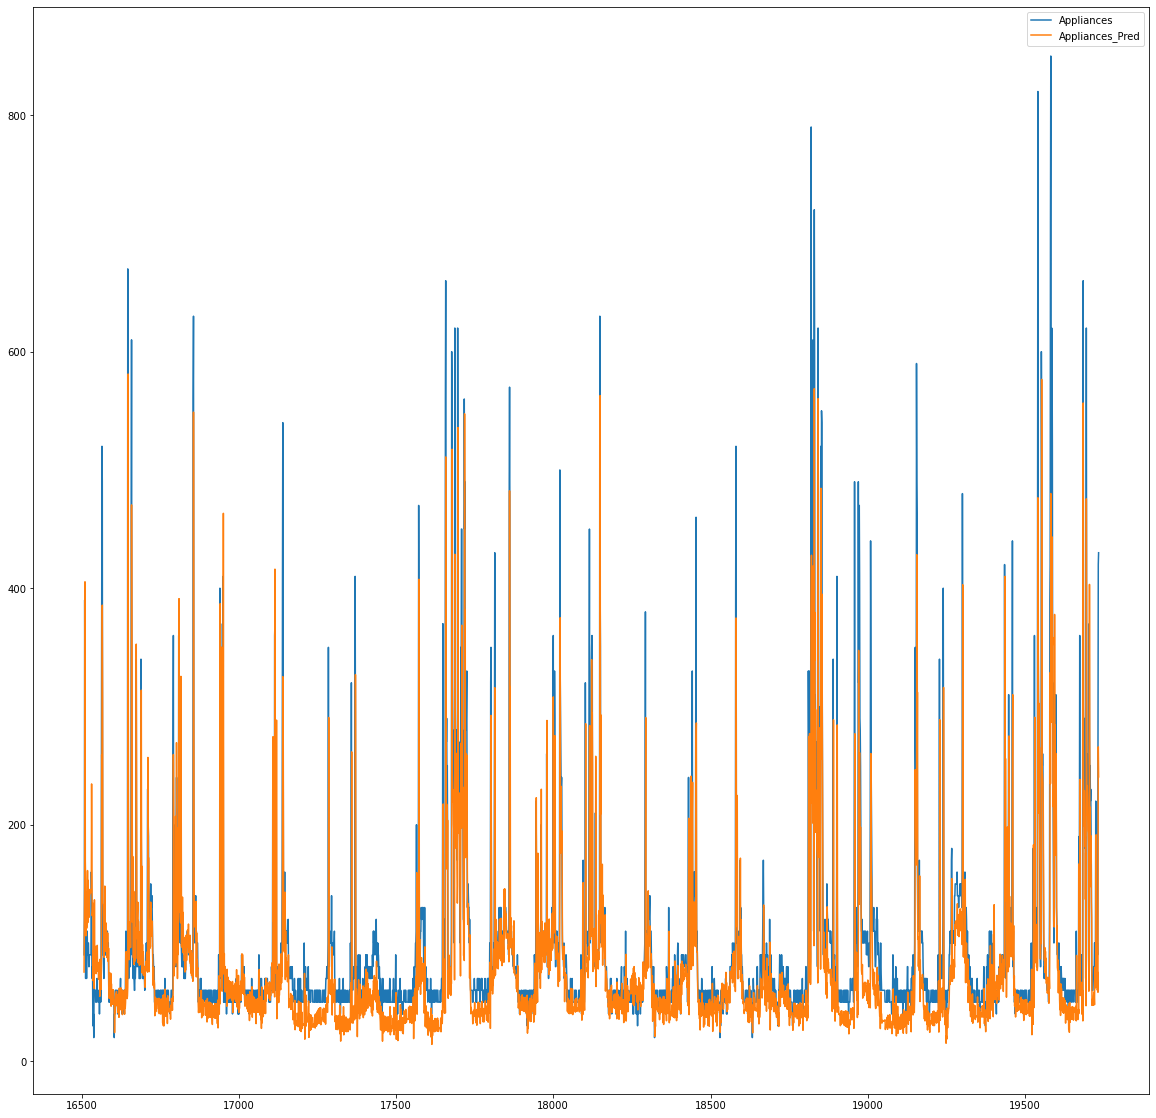

In [386]:
df_final[['Appliances','Appliances_Pred']].plot()